In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import pygrib
from os.path import exists, join
import cartopy.crs as ccrs
import cartopy.feature as cfs
from scipy.ndimage import maximum_filter
from skimage.measure import block_reduce
from hagelslag.evaluation.ProbabilityMetrics import DistributedROC
from hagelslag.evaluation.MetricPlotter import performance_diagram
from matplotlib.colors import LogNorm

Path to files on casper: /glade/p/cisl/aiml/hail

In [35]:
data_path = "/glade/p/cisl/aiml/hail/"

def load_burke_dl(date, path=data_path):
    date_str = date.strftime("%y%m%d")
    out_date = date.strftime("%Y%m%d")
    filename = f"HREFv2_Hail_DL_NMEP_smoothed_25mm_{date_str}_Hours_12-36.grib2"
    full_file = join(path, "burke_dl", filename)
    out_dict = {}
    if not exists(full_file):
        print(full_file + " not found")
        out_dict[out_date] = np.zeros((1059, 1799), dtype=np.float32)
    else:
        with pygrib.open(full_file) as grib_obj:
            data_obj = grib_obj.read()[0]
            out_dict[out_date], out_dict["lat"], out_dict["lon"] = data_obj.data()
            for k, v in out_dict.items():
                out_dict[k] = v.astype(np.float32)
    return out_dict

def load_burke_rf(date, path=data_path):
    date_str = date.strftime("%y%m%d")
    out_date = date.strftime("%Y%m%d")
    filename = f"HREFv2_Random-Forest_Hail_mesh_Cali_NMEP_25mm_{date_str}_Hours_12-36.grib2"
    full_file = join(path, "burke_rf", filename)
    out_dict = {}
    if not exists(full_file):
        out_dict[out_date] = np.zeros((1059, 1799), dtype=np.float32)
    else:
        with pygrib.open(full_file) as grib_obj:
            data_obj = grib_obj.read()[0]
            out_dict[out_date], out_dict["lat"], out_dict["lon"] = data_obj.data()
            for k, v in out_dict.items():
                out_dict[k] = v.astype(np.float32)
    return out_dict

def load_loken_rf(date, path=data_path):
    date_str = date.strftime("%Y%m%d")
    out_date = date.strftime("%Y%m%d")
    filename = f"{date_str}_HREF_probs_any_hail.grib2"
    full_file = join(path, "loken_rf", filename)
    out_dict = {}
    if not exists(full_file):
        print(full_file + " missing")
        out_dict[out_date] = np.zeros((1059, 1799), dtype=np.float32)
    else:
        with pygrib.open(full_file) as grib_obj:
            data_obj = grib_obj.read()[0]
            out_dict[out_date], out_dict["lat"], out_dict["lon"] = data_obj.data()
            out_dict[out_date][out_dict[out_date] < 0] = 0
            for k, v in out_dict.items():
                out_dict[k] = v.astype(np.float32)
                
    return out_dict

def load_spc_outlook(date, path=data_path):
    date_str = date.strftime("%y%m%d")
    out_date = date.strftime("%Y%m%d")
    filename = f"{date_str}_25_spc_outlook.nc"
    full_file = join(path, "SPC_Outlooks", filename)
    out_dict = {}
    if not exists(full_file):
        print(full_file + " missing")
        out_dict[out_date] = np.zeros((1059, 1799), dtype=np.float32)
    else:
        ds = xr.open_dataset(full_file)
        out_dict[out_date] = ds["SPC Hail Probs"].values.astype(np.float32)
        out_dict["lon"] = ds["lon"].values.astype(np.float32)
        out_dict["lat"] = ds["lon"].values.astype(np.float32)
        ds.close()
    return out_dict

def load_lsr_grid(date, path=data_path):
    date_str = date.strftime("%y%m%d")
    out_date = date.strftime("%Y%m%d")
    filename = f"{date_str}_25_lsr_mask.nc"
    full_file = join(path, "LSR", filename)
    out_dict = {}
    if not exists(full_file):
        print(full_file + " missing")
        out_dict[out_date] = np.zeros((1059, 1799), dtype=np.float32)
    else:
        ds = xr.open_dataset(full_file)
        out_dict[out_date] = ds["24_Hour_All_12z_12z"].values.astype(np.float32)
        out_dict["lon"] = ds["Longitude"].values.astype(np.float32)
        out_dict["lat"] = ds["Latitude"].values.astype(np.float32)
        ds.close()
    return out_dict

def attributes_diagram(rel_objs, obj_labels, colors, markers, filename, figsize=(8, 8), xlabel="Forecast Probability",
                       ylabel="Observed Relative Frequency", ticks=np.arange(0, 1.05, 0.05), dpi=300,
                       title="Attributes Diagram", legend_params=None, inset_params=None,
                       inset_position=(0.12, 0.72, 0.25, 0.25), bootstrap_sets=None, ci=(2.5, 97.5), title_fontsize=16,
                      label_fontsize=14):
    """
    Plot reliability curves against a 1:1 diagonal to determine if probability forecasts are consistent with their
    observed relative frequency. Also adds gray areas to show where the climatological probabilities lie and what
    areas result in a positive Brier Skill Score.
    Args:
        rel_objs (list): List of DistributedReliability objects.
        obj_labels (list): List of labels describing the forecast model associated with each curve.
        colors (list): List of colors for each line
        markers (list): List of line markers
        filename (str): Where to save the figure.
        figsize (tuple): (Width, height) of the figure in inches.
        xlabel (str): X-axis label
        ylabel (str): Y-axis label
        ticks (`numpy.ndarray`): Tick value labels for the x and y axes.
        dpi (int): resolution of the saved figure in dots per inch.
        title (str): Title of figure
        legend_params (dict): Keyword arguments for the plot legend.
        inset_params (dict): Keyword arguments for the inset axis.
        inset_position (tuple): Position of the inset axis in normalized axes coordinates (left, bottom, width, height)
        bootstrap_sets (list): A list of arrays of bootstrapped DistributedROC objects. If not None,
            confidence regions will be plotted.
        ci (tuple): tuple of bootstrap confidence interval percentiles
    """
    if legend_params is None:
        legend_params = dict(loc=4, fontsize=10, framealpha=1, frameon=True)
    if inset_params is None:
        inset_params = dict(width="25%", height="25%", loc=2, axes_kwargs=dict(facecolor='white'))
    fig, ax = plt.subplots(figsize=figsize)
    plt.plot(ticks, ticks, "k--")
    inset_hist = inset_axes(ax, **inset_params)
    ip = InsetPosition(ax, inset_position)
    inset_hist.set_axes_locator(ip)
    climo = rel_objs[0].climatology()
    no_skill = 0.5 * ticks + 0.5 * climo
    skill_x = [climo, climo, 1, 1, climo, climo, 0, 0, climo]
    skill_y = [climo, 1, 1, no_skill[-1], climo, 0, 0, no_skill[0], climo]
    f = ax.fill(skill_x, skill_y, "0.8")
    f[0].set_zorder(1)
    ax.plot(ticks, np.ones(ticks.shape) * climo, "k--")
    if bootstrap_sets is not None:
        for b, b_set in enumerate(bootstrap_sets):
            brel_curves = np.vstack([b_rel.reliability_curve()["Positive_Relative_Freq"].values for b_rel in b_set])
            rel_range = np.nanpercentile(brel_curves, ci, axis=0)
            fb = ax.fill_between(b_set[0].thresholds[:-1], rel_range[1], rel_range[0], alpha=0.5, color=colors[b])
            fb.set_zorder(2)
    for r, rel_obj in enumerate(rel_objs):
        rel_curve = rel_obj.reliability_curve()
        ax.plot(rel_curve["Bin_Start"], rel_curve["Positive_Relative_Freq"], color=colors[r],
                marker=markers[r], label=obj_labels[r])
        inset_hist.semilogy(rel_curve["Bin_Start"] * 100, rel_obj.frequencies["Total_Freq"][:-1], color=colors[r],
                            marker=markers[r])
    inset_hist.set_xlabel("Forecast Probability")
    inset_hist.set_ylabel("Frequency")
    ax.annotate("No Skill", (0.6, no_skill[12]), rotation=22.5)
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)
    ax.set_xticks(ticks)
    ax.set_xticklabels((ticks * 100).astype(int))
    ax.set_yticks(ticks)
    ax.set_yticklabels((ticks * 100).astype(int))
    ax.legend(**legend_params)
    ax.set_title(title, fontsize=title_fontsize)
    plt.savefig(filename, dpi=dpi, bbox_inches="tight", facecolor="w")
    plt.close()

def performance_diagram(roc_objs, obj_labels, colors, markers, filename, figsize=(8, 8),
                        xlabel="Success Ratio (1-FAR)",
                        ylabel="Probability of Detection", ticks=np.arange(0, 1.1, 0.1),
                        dpi=300, csi_cmap="Blues",
                        csi_label="Critical Success Index", title="Performance Diagram",
                        legend_params=None, bootstrap_sets=None, ci=(2.5, 97.5), label_fontsize=14,
                        title_fontsize=16, tick_fontsize=12):
    """
    Draws a performance diagram from a set of DistributedROC objects.
    A performance diagram is a variation on the ROC curve in which the Probability of False Detection on the
    x-axis has been replaced with the Success Ratio (1-False Alarm Ratio or Precision). The diagram also shows
    the Critical Success Index (CSI or Threat Score) as a series of curved contours, and the frequency bias as
    angled diagonal lines. Points along the 1:1 diagonal are unbiased, and better performing models should appear
    in the upper right corner. The performance diagram is particularly useful for displaying verification for
    severe weather warnings as it displays all three commonly used statistics (POD, FAR, and CSI) simultaneously
    on the same chart.
    Args:
        roc_objs (list): DistributedROC objects being plotted.
        obj_labels: list or array of labels describing each DistributedROC object.
        obj_labels (list): Label describing the forecast associated with a DistributedROC object.
        colors (list): List of matplotlib-readable colors (names or hex-values) for each curve.
        markers (list): Matplotlib marker (e.g. *, o, v, etc.) for each curve.
        filename (str): Name of figure file being saved.
        figsize (tuple): (Width, height) of the figure in inches.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): The title of the figure.
        ticks (numpy.ndarray): Values shown on the x and y axes.
        dpi (int): Figure resolution in dots per inch.
        csi_cmap (str): Matplotlib colormap used to fill CSI contours.
        csi_label (str): Label for CSI colormap.
        legend_params (None or dict): Keyword arguments for the formatting of the figure legend.
        bootstrap_sets (list): A list of arrays of bootstrapped DistributedROC objects. If not None,
            confidence regions will be plotted.
        ci (tuple): tuple of bootstrap confidence interval percentiles.
        label_fontsize (int): Font size of the x and y axis labels.
        title_fontsize (int): Font size of the title.
        tick_fontsize (int): Font size of the x and y tick labels.
    Examples:
        >>> from hagelslag.evaluation.ProbabilityMetrics import DistributedROC
        >>> import numpy as np
        >>> forecasts = np.random.random(1000)
        >>> obs = np.random.random_integers(0, 1, 1000)
        >>> roc = DistributedROC()
        >>> roc.update(forecasts, obs)
        >>> performance_diagram([roc], ["Random"], ["orange"], ["o"], "random_performance.png")
    """
    if legend_params is None:
        legend_params = dict(loc=4, fontsize=10, framealpha=1, frameon=True)
    plt.figure(figsize=figsize)
    grid_ticks = np.arange(0, 1.01, 0.01)
    sr_g, pod_g = np.meshgrid(grid_ticks, grid_ticks)
    bias = pod_g / sr_g
    csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)
    csi_contour = plt.contourf(sr_g, pod_g, csi, np.arange(0.1, 1.1, 0.1), extend="max", cmap=csi_cmap)
    b_contour = plt.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors="k", linestyles="dashed")
    plt.clabel(b_contour, fmt="%1.1f", manual=[(0.2, 0.9), (0.4, 0.9), (0.6, 0.9), (0.7, 0.7)])
    if bootstrap_sets is not None:
        for b, b_set in enumerate(bootstrap_sets):
            perf_curves = np.dstack([b_roc.performance_curve().values for b_roc in b_set])
            pod_range = np.nanpercentile(perf_curves[:, 0], ci, axis=1)
            sr_range = np.nanpercentile(1 - perf_curves[:, 1], ci, axis=1)
            pod_poly = np.concatenate((pod_range[1], pod_range[0, ::-1]))
            sr_poly = np.concatenate((sr_range[1], sr_range[0, ::-1]))
            pod_poly[np.isnan(pod_poly)] = 0
            sr_poly[np.isnan(sr_poly)] = 1
            plt.fill(sr_poly, pod_poly, alpha=0.5, color=colors[b])
    for r, roc_obj in enumerate(roc_objs):
        perf_data = roc_obj.performance_curve()
        plt.plot(1 - perf_data["FAR"], perf_data["POD"], marker=markers[r], color=colors[r], label=obj_labels[r])
        for t, threshold in enumerate(perf_data["Thresholds"]):
            if ~np.isnan(perf_data.loc[t, "FAR"]) and ~np.isnan(perf_data.loc[t, "POD"]):
                plt.text(1-perf_data.loc[t, "FAR"], perf_data.loc[t, "POD"], "{0:d}".format(int(threshold * 100)),
                     color='white', ha='center', va='center', fontsize=6)
    cbar = plt.colorbar(csi_contour)
    cbar.set_label(csi_label)
    plt.xlabel(xlabel, fontsize=label_fontsize)
    plt.ylabel(ylabel, fontsize=label_fontsize)
    plt.xticks(ticks, fontsize=tick_fontsize)
    plt.yticks(ticks, fontsize=tick_fontsize)
    plt.title(title, fontsize=title_fontsize)
    plt.legend(**legend_params)
    plt.savefig(filename, dpi=dpi, bbox_inches="tight", facecolor="w")
    plt.close()

In [3]:
all_dates = pd.date_range(start="2021-05-03", end="2021-06-04", freq="1D")
all_data = {}
data_funcs = {"burke_dl": load_burke_dl,
              "burke_rf": load_burke_rf,
              "loken_rf": load_loken_rf,
              "spc_nws": load_spc_outlook,
              "lsr": load_lsr_grid,
             }
for k in data_funcs.keys():
    all_data[k] = {}
for date in all_dates:
    print(date)
    for k, func in data_funcs.items():
        all_data[k].update(func(date))

2021-05-03 00:00:00
2021-05-04 00:00:00
2021-05-05 00:00:00
2021-05-06 00:00:00
2021-05-07 00:00:00
2021-05-08 00:00:00
2021-05-09 00:00:00
2021-05-10 00:00:00
2021-05-11 00:00:00
2021-05-12 00:00:00
/glade/p/cisl/aiml/hail/LSR/210512_25_lsr_mask.nc missing
2021-05-13 00:00:00
2021-05-14 00:00:00
2021-05-15 00:00:00
2021-05-16 00:00:00
2021-05-17 00:00:00
/glade/p/cisl/aiml/hail/burke_dl/HREFv2_Hail_DL_NMEP_smoothed_25mm_210517_Hours_12-36.grib2 not found
2021-05-18 00:00:00
2021-05-19 00:00:00
2021-05-20 00:00:00
2021-05-21 00:00:00
2021-05-22 00:00:00
2021-05-23 00:00:00
2021-05-24 00:00:00
2021-05-25 00:00:00
2021-05-26 00:00:00
2021-05-27 00:00:00
2021-05-28 00:00:00
2021-05-29 00:00:00
2021-05-30 00:00:00
2021-05-31 00:00:00
2021-06-01 00:00:00
2021-06-02 00:00:00
2021-06-03 00:00:00
2021-06-04 00:00:00


In [25]:
class DistributedReliability(object):
    """
    A container for the statistics required to generate reliability diagrams and calculate the Brier Score.
    DistributedReliabilty objects accept binary probabilistic forecasts and associated observations. The
    forecasts are then discretized into the different probability bins. The total frequency and the frequency
    of positive events for each probability bin are tracked. The Brier Score, Brier Skill Score, and
    Brier score components can all be derived from this information. Like the DistributedROC object,
    DistributedReliability objects can be summed together, and their contents can be output as a string.
    Attributes:
        thresholds (numpy.ndarray): Array of probability thresholds
        obs_threshold (float): Split value (>=) for determining positive observation events
        frequencies (pandas.DataFrame): Stores the total and positive frequencies for each bin
    Examples:
        >>> forecasts = np.random.random(1000)
        >>> obs = np.random.random_integers(0, 1, 1000)
        >>> rel = DistributedReliability()
        >>> rel.update(forecasts, obs)
        >>> print(rel.brier_score())
    """

    def __init__(self, thresholds=np.arange(0, 1.1, 0.05), obs_threshold=1.0, input_str=None):
        """
        Initialize the DistributedReliability object.
        Args:
            thresholds (numpy.ndarray): Array of probability thresholds
            obs_threshold (float): Split value for observations
            input_str (str): String containing information to initialize the object from a text representation.
        """
        self.thresholds = thresholds
        self.obs_threshold = obs_threshold
        self.frequencies = pd.DataFrame(np.zeros((self.thresholds.size, 2), dtype=int),
                                        columns=["Total_Freq", "Positive_Freq"])
        if input_str is not None:
            self.from_str(input_str)

    def update(self, forecasts, observations):
        """
        Update the statistics with a set of forecasts and observations.
        Args:
            forecasts (numpy.ndarray): Array of forecast probability values
            observations (numpy.ndarray): Array of observation values
        """
        for t, threshold in enumerate(self.thresholds[:-1]):
            self.frequencies.loc[t, "Positive_Freq"] += np.count_nonzero((threshold <= forecasts) &
                                                                         (forecasts < self.thresholds[t + 1]) &
                                                                         (observations >= self.obs_threshold))
            self.frequencies.loc[t, "Total_Freq"] += np.count_nonzero((threshold <= forecasts) &
                                                                      (forecasts < self.thresholds[t + 1]))

    def clear(self):
        self.frequencies.loc[:, :] = 0

    def __add__(self, other):
        """
        Add two DistributedReliability objects together and combine their values.
        Args:
            other: a DistributedReliability object
        Returns:
            A DistributedReliability Object
        """
        sum_rel = DistributedReliability(self.thresholds, self.obs_threshold)
        sum_rel.frequencies = self.frequencies + other.frequencies
        return sum_rel

    def merge(self, other_rel):
        """
        Ingest another DistributedReliability and add its contents to the current object.
        Args:
            other_rel: a Distributed reliability object.
        """
        if other_rel.thresholds.size == self.thresholds.size and np.all(other_rel.thresholds == self.thresholds):
            self.frequencies += other_rel.frequencies
        else:
            print("Input table thresholds do not match.")

    def reliability_curve(self):
        """
        Calculates the reliability diagram statistics. The key columns are Bin_Start and Positive_Relative_Freq
        Returns:
            pandas.DataFrame
        """
        total = self.frequencies["Total_Freq"].sum()
        curve = pd.DataFrame(columns=["Bin_Start", "Bin_End", "Bin_Center",
                                      "Positive_Relative_Freq", "Total_Relative_Freq"])
        curve["Bin_Start"] = self.thresholds[:-1]
        curve["Bin_End"] = self.thresholds[1:]
        curve["Bin_Center"] = 0.5 * (self.thresholds[:-1] + self.thresholds[1:])
        curve["Positive_Relative_Freq"] = self.frequencies["Positive_Freq"] / self.frequencies["Total_Freq"]
        curve["Total_Relative_Freq"] = self.frequencies["Total_Freq"] / total
        return curve

    def brier_score_components(self):
        """
        Calculate the components of the Brier score decomposition: reliability, resolution, and uncertainty.
        """
        rel_curve = self.reliability_curve()
        total = self.frequencies["Total_Freq"].sum()
        climo_freq = float(self.frequencies["Positive_Freq"].sum()) / self.frequencies["Total_Freq"].sum()
        reliability = np.sum(self.frequencies["Total_Freq"] * (rel_curve["Bin_Start"] -
                                                               rel_curve["Positive_Relative_Freq"]) ** 2) / total
        resolution = np.sum(self.frequencies["Total_Freq"] * (rel_curve["Positive_Relative_Freq"] - climo_freq) ** 2) \
                     / total
        uncertainty = climo_freq * (1 - climo_freq)
        return reliability, resolution, uncertainty

    def climatology(self):
        """
        Calculates the sample climatological relative frequency of the event being forecast.
        """
        return float(self.frequencies["Positive_Freq"].sum()) / self.frequencies["Total_Freq"].sum()

    def brier_score(self):
        """
        Calculate the Brier Score
        """
        reliability, resolution, uncertainty = self.brier_score_components()
        return reliability - resolution + uncertainty

    def brier_skill_score(self):
        """
        Calculate the Brier Skill Score
        """
        reliability, resolution, uncertainty = self.brier_score_components()
        return (resolution - reliability) / uncertainty

    def __str__(self):
        out_str = "Obs_Threshold:{0:0.2f}".format(self.obs_threshold) + ";"
        out_str += "Thresholds:" + " ".join(["{0:0.2f}".format(t) for t in self.thresholds]) + ";"
        for col in self.frequencies.columns:
            out_str += col + ":" + " ".join(["{0:d}".format(t) for t in self.frequencies[col]]) + ";"
        out_str = out_str.rstrip(";")
        return out_str

    def __repr__(self):
        return self.__str__()

    def from_str(self, in_str):
        """
        Updates the object attributes with the information contained in the input string
        Args:
            in_str (str): String output by the __str__ method containing all of the attribute values
        """
        parts = in_str.split(";")
        for part in parts:
            var_name, value = part.split(":")
            if var_name == "Obs_Threshold":
                self.obs_threshold = float(value)
            elif var_name == "Thresholds":
                self.thresholds = np.array(value.split(), dtype=float)
                self.frequencies = pd.DataFrame(columns=self.frequencies.columns,
                                                data=np.zeros((self.thresholds.size,
                                                               self.frequencies.columns.size)))
            elif var_name in ["Positive_Freq", "Total_Freq"]:
                self.frequencies[var_name] = np.array(value.split(), dtype=int)

class DistributedROC(object):
    """
    ROC sparse representation that can be aggregated and can generate ROC curves and performance diagrams.
    A DistributedROC object is given a specified set of thresholds (could be probability or real-valued) and then
    stores a pandas DataFrame of contingency tables for each threshold. The contingency tables are updated with a
    set of forecasts and observations, but the original forecast and observation values are not kept. DistributedROC
    objects can be combined by adding them together or by storing them in an iterable and summing the contents of the
    iterable together. This is especially useful when verifying large numbers of cases in parallel.
    Attributes:
        thresholds (numpy.ndarray): List of probability thresholds in increasing order.
        obs_threshold (float):  Observation values >= obs_threshold are positive events.
        contingency_tables (pandas.DataFrame): Stores contingency table counts for each probability threshold
    Examples:
        >>> import numpy as np
        >>> forecasts = np.random.random(size=1000)
        >>> obs = np.random.random_integers(0, 1, size=1000)
        >>> roc = DistributedROC(thresholds=np.arange(0, 1.1, 0.1), obs_threshold=1)
        >>> roc.update(forecasts, obs)
        >>> print(roc.auc())
    """

    def __init__(self, thresholds=np.arange(0, 1.1, 0.1), obs_threshold=1.0, input_str=None):
        """
        Initializes the DistributedROC object. If input_str is not None, then the DistributedROC object is
         initialized with the contents of input_str. Otherwise an empty contingency table is created.
        Args:
            thresholds (numpy.array): Array of thresholds in increasing order.
            obs_threshold (float): Split threshold (>= is positive event) (< is negative event)
            input_str (None or str): String containing information for DistributedROC
        """
        self.thresholds = thresholds
        self.obs_threshold = obs_threshold
        self.contingency_tables = pd.DataFrame(np.zeros((thresholds.size, 4), dtype=int),
                                               columns=["TP", "FP", "FN", "TN"])
        if input_str is not None:
            self.from_str(input_str)

    def update(self, forecasts, observations):
        """
        Update the ROC curve with a set of forecasts and observations
        Args:
            forecasts: 1D array of forecast values
            observations: 1D array of observation values.
        """
        for t, threshold in enumerate(self.thresholds):
            tp = np.count_nonzero((forecasts >= threshold) & (observations >= self.obs_threshold))
            fp = np.count_nonzero((forecasts >= threshold) &
                                  (observations < self.obs_threshold))
            fn = np.count_nonzero((forecasts < threshold) &
                                  (observations >= self.obs_threshold))
            tn = np.count_nonzero((forecasts < threshold) &
                                  (observations < self.obs_threshold))
            self.contingency_tables.iloc[t] += [tp, fp, fn, tn]

    def clear(self):
        self.contingency_tables.loc[:, :] = 0

    def __add__(self, other):
        """
        Add two DistributedROC objects together and combine their contingency table values.
        Args:
            other: Another DistributedROC object.
        """
        sum_roc = DistributedROC(self.thresholds, self.obs_threshold)
        sum_roc.contingency_tables = self.contingency_tables + other.contingency_tables
        return sum_roc

    def merge(self, other_roc):
        """
        Ingest the values of another DistributedROC object into this one and update the statistics inplace.
        Args:
            other_roc: another DistributedROC object.
        """
        if other_roc.thresholds.size == self.thresholds.size and np.all(other_roc.thresholds == self.thresholds):
            self.contingency_tables += other_roc.contingency_tables
        else:
            print("Input table thresholds do not match.")

    def roc_curve(self):
        """
        Generate a ROC curve from the contingency table by calculating the probability of detection (TP/(TP+FN)) and the
        probability of false detection (FP/(FP+TN)).
        Returns:
            A pandas.DataFrame containing the POD, POFD, and the corresponding probability thresholds.
        """
        pod = self.contingency_tables["TP"].astype(float) / (self.contingency_tables["TP"] +
                                                             self.contingency_tables["FN"])
        pofd = self.contingency_tables["FP"].astype(float) / (self.contingency_tables["FP"] +
                                                              self.contingency_tables["TN"])
        return pd.DataFrame({"POD": pod, "POFD": pofd, "Thresholds": self.thresholds},
                            columns=["POD", "POFD", "Thresholds"])

    def performance_curve(self):
        """
        Calculate the Probability of Detection and False Alarm Ratio in order to output a performance diagram.
        Returns:
            pandas.DataFrame containing POD, FAR, and probability thresholds.
        """
        pod = self.contingency_tables["TP"] / (self.contingency_tables["TP"] + self.contingency_tables["FN"])
        far = self.contingency_tables["FP"] / (self.contingency_tables["FP"] + self.contingency_tables["TP"])
        far[(self.contingency_tables["FP"] + self.contingency_tables["TP"]) == 0] = np.nan
        return pd.DataFrame({"POD": pod, "FAR": far, "Thresholds": self.thresholds},
                            columns=["POD", "FAR", "Thresholds"])

    def auc(self):
        """
        Calculate the Area Under the ROC Curve (AUC).
        """
        roc_curve = self.roc_curve()
        return np.abs(np.trapz(roc_curve['POD'], x=roc_curve['POFD']))

    def max_csi(self):
        """
        Calculate the maximum Critical Success Index across all probability thresholds
        Returns:
            The maximum CSI as a float
        """
        csi = self.contingency_tables["TP"] / (self.contingency_tables["TP"] + self.contingency_tables["FN"] +
                                               self.contingency_tables["FP"])
        return csi.max()

    def max_threshold_score(self, score="ets"):
        cts = self.get_contingency_tables()
        scores = np.array([getattr(ct, score)() for ct in cts])
        return self.thresholds[scores.argmax()], scores.max()

    def get_contingency_tables(self):
        """
        Create an Array of ContingencyTable objects for each probability threshold.
        Returns:
            Array of ContingencyTable objects
        """
        return np.array([ContingencyTable(*ct) for ct in self.contingency_tables.values])

    def __str__(self):
        """
        Output the information within the DistributedROC object to a string.
        """
        out_str = "Obs_Threshold:{0:0.2f}".format(self.obs_threshold) + ";"
        out_str += "Thresholds:" + " ".join(["{0:0.2f}".format(t) for t in self.thresholds]) + ";"
        for col in self.contingency_tables.columns:
            out_str += col + ":" + " ".join(["{0:d}".format(t) for t in self.contingency_tables[col]]) + ";"
        out_str = out_str.rstrip(";")
        return out_str

    def __repr__(self):
        return self.__str__()

    def from_str(self, in_str):
        """
        Read the DistributedROC string and parse the contingency table values from it.
        Args:
            in_str (str): The string output from the __str__ method
        """
        parts = in_str.split(";")
        for part in parts:
            var_name, value = part.split(":")
            if var_name == "Obs_Threshold":
                self.obs_threshold = float(value)
            elif var_name == "Thresholds":
                self.thresholds = np.array(value.split(), dtype=float)
                self.contingency_tables = pd.DataFrame(columns=self.contingency_tables.columns,
                                                       data=np.zeros((self.thresholds.size,
                                                                      self.contingency_tables.columns.size)))
            elif var_name in self.contingency_tables.columns:
                self.contingency_tables[var_name] = np.array(value.split(), dtype=int)

def bootstrap(score_objs, n_boot=1000):
    """
    Given a set of DistributedROC or DistributedReliability objects, this function performs a
    bootstrap resampling of the objects and returns n_boot aggregations of them.
    Args:
        score_objs: A list of DistributedROC or DistributedReliability objects. Objects must have an __add__ method
        n_boot (int): Number of bootstrap samples
    Returns:
        An array of DistributedROC or DistributedReliability
    """
    all_samples = np.random.choice(score_objs, size=(n_boot, len(score_objs)), replace=True)
    return all_samples.sum(axis=1)

In [10]:
"20210512" in all_data["burke_dl"].keys() 

True

In [5]:
lsr_dates = sorted(list(all_data["lsr"].keys()))[:-2]
for lsr_date in lsr_dates:
    print(lsr_date, all_data["lsr"][lsr_date].max())

20210503 1.0
20210504 1.0
20210505 1.0
20210506 1.0
20210507 1.0
20210508 1.0
20210509 1.0
20210510 1.0
20210511 1.0
20210512 0.0
20210513 1.0
20210514 1.0
20210515 1.0
20210516 1.0
20210517 1.0
20210518 1.0
20210519 1.0
20210520 1.0
20210521 1.0
20210522 1.0
20210523 1.0
20210524 1.0
20210525 1.0
20210526 1.0
20210527 1.0
20210528 1.0
20210529 1.0
20210530 1.0
20210531 1.0
20210601 1.0
20210602 1.0
20210603 1.0
20210604 1.0


In [26]:
lsr_dates = sorted(list(all_data["lsr"].keys()))[:-2]
forecasts = ['burke_dl', 'burke_rf', 'loken_rf', 'spc_nws']
thresholds = np.array([0, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7])
drocs = {f: [] for f in forecasts}
drels = {f: [] for f in forecasts}
final_lsr_dates = []
for lsr_date in lsr_dates:
    print(lsr_date)
    all_avail = []
    for mod in forecasts:
        all_avail.append(lsr_date in all_data[mod].keys())
    if all(all_avail) and all_data["lsr"][lsr_date].max() > 0:
        final_lsr_dates.append(lsr_date)
        for mod in forecasts:
            print(mod)
            if lsr_date in all_data[mod].keys():
                drocs[mod].append(DistributedROC(thresholds=thresholds))
                drocs[mod][-1].update(all_data[mod][lsr_date].ravel(), all_data["lsr"][lsr_date].ravel())
                drels[mod].append(DistributedReliability(thresholds=thresholds))
                drels[mod][-1].update(all_data[mod][lsr_date].ravel(), all_data["lsr"][lsr_date].ravel())

            

20210503
burke_dl
burke_rf
loken_rf
spc_nws
20210504
burke_dl
burke_rf
loken_rf
spc_nws
20210505
burke_dl
burke_rf
loken_rf
spc_nws
20210506
burke_dl
burke_rf
loken_rf
spc_nws
20210507
burke_dl
burke_rf
loken_rf
spc_nws
20210508
burke_dl
burke_rf
loken_rf
spc_nws
20210509
burke_dl
burke_rf
loken_rf
spc_nws
20210510
burke_dl
burke_rf
loken_rf
spc_nws
20210511
burke_dl
burke_rf
loken_rf
spc_nws
20210512
20210513
burke_dl
burke_rf
loken_rf
spc_nws
20210514
burke_dl
burke_rf
loken_rf
spc_nws
20210515
burke_dl
burke_rf
loken_rf
spc_nws
20210516
burke_dl
burke_rf
loken_rf
spc_nws
20210517
burke_dl
burke_rf
loken_rf
spc_nws
20210518
burke_dl
burke_rf
loken_rf
spc_nws
20210519
burke_dl
burke_rf
loken_rf
spc_nws
20210520
burke_dl
burke_rf
loken_rf
spc_nws
20210521
burke_dl
burke_rf
loken_rf
spc_nws
20210522
burke_dl
burke_rf
loken_rf
spc_nws
20210523
burke_dl
burke_rf
loken_rf
spc_nws
20210524
burke_dl
burke_rf
loken_rf
spc_nws
20210525
burke_dl
burke_rf
loken_rf
spc_nws
20210526
burke_dl
burke

In [27]:
total_rocs = []
total_rels = []
boot_rocs = []
boot_rels = []
for mod in forecasts:
    print(mod)
    total_rocs.append(np.sum(drocs[mod]))
    boot_rocs.append(bootstrap(drocs[mod]))
    total_rels.append(np.sum(drels[mod]))
    boot_rels.append(bootstrap(drels[mod]))

burke_dl
burke_rf
loken_rf
spc_nws


In [8]:
max_csi_frame = pd.DataFrame(0.0, index=final_lsr_dates, columns=forecasts)
for mod in forecasts:
    print(mod)
    for f, fore in enumerate(drocs[mod]):
        print(fore.max_csi())
        max_csi_frame.loc[final_lsr_dates[f], mod] = fore.max_csi()

burke_dl
0.16246767012931948
0.08810035142522452
0.002774597785675706
0.019411631931382137
0.11511701454775458
0.22116385911179173
0.07626882454133951
0.0931461720260689
0.033898891966759
0.0021961629086771003
0.254039020000818
0.10243659870711089
0.15834955767325887
0.007856636332953833
0.02658957594500563
0.008117253107522922
0.07351198314458783
0.15247160988643954
0.09540574858594021
0.18439684730818898
0.14269177825053184
0.12564432989690721
0.31567011698138625
0.15873217383944818
0.11243857077754923
0.17469550990728958
0.11229135053110774
0.09634868091082355
0.0024578282881331007
0.11539168812063258
0.0005070490845559462
0.02386755335816998
burke_rf
0.11405988644662755
0.10507311789131613
0.002774597785675706
0.0011741913065752088
0.018632260192093655
0.3545950482584977
0.17348648001914332
0.09018012230232945
0.090626902008521
0.11207905343908464
0.19316195862857868
0.14456505576208178
0.1984769879554625
0.007856636332953833
0.04604449938195303
0.0008907477189352389
0.001274971248

In [64]:
max_csi_frame

,burke_dl,burke_rf,loken_rf,spc_nws
20210503,0.162468,0.114060,0.175096,0.133019
20210504,0.088100,0.105073,0.106287,0.047206
20210505,0.002775,0.002775,0.038644,0.002775
20210506,0.019412,0.001174,0.064715,0.044611
20210507,0.115117,0.018632,0.181075,0.029264
20210508,0.221164,0.354595,0.367743,0.182793
20210509,0.076269,0.173486,0.163829,0.119928
20210510,0.093146,0.090180,0.118533,0.109154
20210511,0.033899,0.090627,0.051813,0.041790
20210513,0.002196,0.112079,0.216094,0.141213


In [32]:
forecasts

['burke_dl', 'burke_rf', 'loken_rf', 'spc_nws']

In [36]:
f_names = ["Burke U-Net", "Burke RF", "Loken RF", "SPC Hail"]
performance_diagram(total_rocs, f_names, ["red", "blue", "green", "purple"], ["o", "o", "o", "o"], 
                    "hail_perf_2021.png", bootstrap_sets=boot_rocs, title="HWT 2021 Hail Performance")

/glade/scratch/dgagne/ipykernel_265763/2341283449.py:211: RuntimeWarning: divide by zero encountered in true_divide
  bias = pod_g / sr_g
/glade/scratch/dgagne/ipykernel_265763/2341283449.py:211: RuntimeWarning: invalid value encountered in true_divide
  bias = pod_g / sr_g
/glade/scratch/dgagne/ipykernel_265763/2341283449.py:212: RuntimeWarning: divide by zero encountered in true_divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)
/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply

In [38]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition

attributes_diagram(total_rels, f_names, ["red", "blue", "green", "purple"], ["o", "o", "o", "o"], 
                   "hail_attr_2021.png", bootstrap_sets=boot_rels, title="HWT 2021 Hail Reliability")

/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [43]:
for f, forecast in enumerate(forecasts):
    print(forecast, total_rels[f].brier_skill_score())

burke_dl 0.03720692232589094
burke_rf 0.07561677041498002
loken_rf 0.1423161001734955
spc_nws 0.10130906092595532


In [46]:
for f, forecast in enumerate(forecasts):
    rel_comps = total_rels[f].brier_score_components()
    print(forecast, rel_comps[0] / rel_comps[2], rel_comps[1] / rel_comps[2])

burke_dl 0.018815984659196594 0.05602290698508754
burke_rf 0.0061741768110946185 0.08179094722607465
loken_rf 0.006904248249995285 0.1492203484234908
spc_nws 0.005001299145801071 0.10631036007175639


In [10]:
proj_params = {'a': 6371229.0,
 'b': 6371229.0,
 'proj': 'lcc',
 'lon_0': 262.5,
 'lat_0': 38.5,
 'lat_1': 38.5,
 'lat_2': 38.5}

/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


Text(0.5, 1.0, 'ML Hail Composite 20210525')

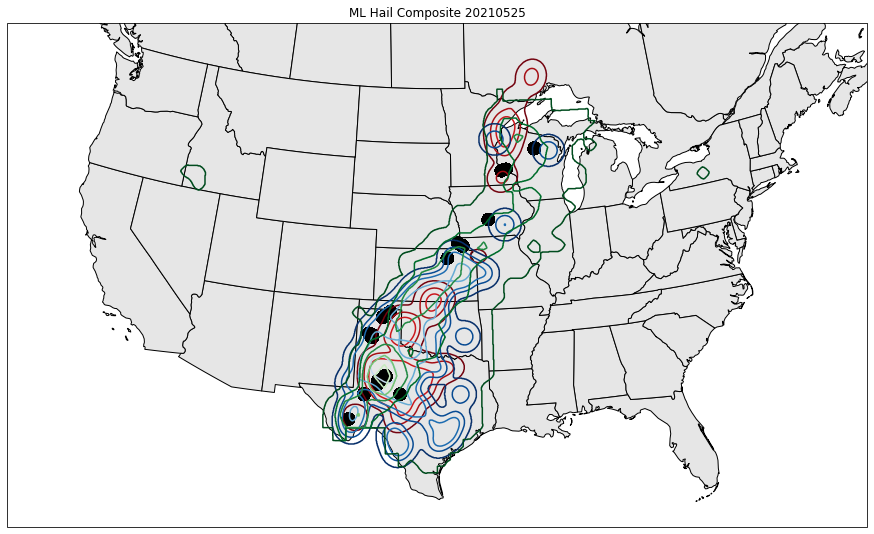

In [42]:
plot_date = "20210525"
fig = plt.figure(figsize=(12, 7))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_latitude=proj_params["lat_0"],
                                                   central_longitude=proj_params["lon_0"],
                                                   standard_parallels=[proj_params["lat_1"], proj_params["lat_2"]]
                                                  ))
ax.add_feature(cfs.STATES, facecolor="0.9", zorder=0)
ax.contourf(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], all_data["lsr"][plot_date], np.array([0.5, 1]), 
            transform=ccrs.PlateCarree(), cmap="binary", vmax=0.5, vmin=-1)
ax.contour(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], all_data["burke_dl"][plot_date], np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4]), 
            transform=ccrs.PlateCarree(), cmap="Reds_r", vmax=0.4, vmin=0)
ax.contour(all_data["burke_rf"]["lon"], all_data["burke_rf"]["lat"], all_data["burke_rf"][plot_date], np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4]), 
            transform=ccrs.PlateCarree(), cmap="Blues_r")
ax.contour(all_data["loken_rf"]["lon"], all_data["loken_rf"]["lat"], all_data["loken_rf"][plot_date], np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4]), 
            transform=ccrs.PlateCarree(), cmap="Greens_r", vmax=0.4, vmin=0)

#ax.contour(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], all_data["spc_nws"][plot_date], np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4]), 
#            transform=ccrs.PlateCarree(), cmap="Purples_r", vmax=0.4, vmin=0)
ax.set_title("ML Hail Composite " + plot_date)

/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


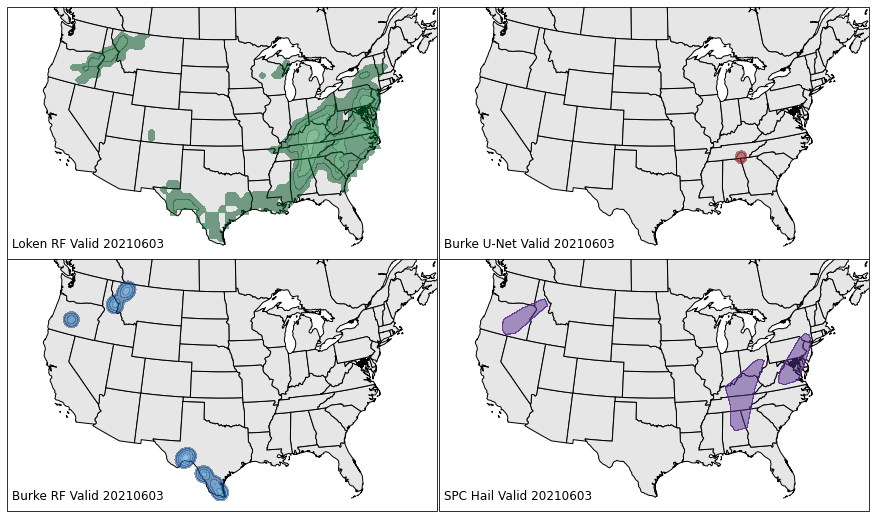

In [41]:
plot_date = "20210603"
contours = np.array([0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.3, 0.45])
fig = plt.figure(figsize=(12, 7))
ax = fig.add_axes([0, 0.5, 0.5, 0.5], 
                  projection=ccrs.LambertConformal(central_latitude=proj_params["lat_0"],
                                                   central_longitude=proj_params["lon_0"],
                                                   standard_parallels=[proj_params["lat_1"], proj_params["lat_2"]]
                                                  ))
ax.add_feature(cfs.STATES, facecolor="0.9", zorder=0)
ax.contourf(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], all_data["lsr"][plot_date], np.array([0.5, 1]), 
            transform=ccrs.PlateCarree(), cmap="binary", vmax=0.5, vmin=-1)
ax.contourf(all_data["loken_rf"]["lon"], all_data["loken_rf"]["lat"], all_data["loken_rf"][plot_date],  contours, 
            transform=ccrs.PlateCarree(), cmap="Greens_r", vmax=0.45, vmin=0, alpha=0.5)
ax.set_title("Loken RF Valid " + plot_date, loc="left", y=0.02, x=0.01)
ax = fig.add_axes([0.5, 0.5, 0.5, 0.5], 
                  projection=ccrs.LambertConformal(central_latitude=proj_params["lat_0"],
                                                   central_longitude=proj_params["lon_0"],
                                                   standard_parallels=[proj_params["lat_1"], proj_params["lat_2"]]
                                                  ))
ax.add_feature(cfs.STATES, facecolor="0.9", zorder=0)
ax.contourf(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], all_data["lsr"][plot_date], np.array([0.5, 1]), 
            transform=ccrs.PlateCarree(), cmap="binary", vmax=0.5, vmin=-1)
ax.contourf(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], all_data["burke_dl"][plot_date], contours, 
            transform=ccrs.PlateCarree(), cmap="Reds_r", vmax=0.45, vmin=0, alpha=0.5)
ax.set_title("Burke U-Net Valid " + plot_date, loc="left", y=0.02, x=0.01)

ax = fig.add_axes([0, 0, 0.5, 0.5], 
                  projection=ccrs.LambertConformal(central_latitude=proj_params["lat_0"],
                                                   central_longitude=proj_params["lon_0"],
                                                   standard_parallels=[proj_params["lat_1"], proj_params["lat_2"]]
                                                  ))
ax.add_feature(cfs.STATES, facecolor="0.9", zorder=0)
ax.contourf(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], all_data["lsr"][plot_date], np.array([0.5, 1]), 
            transform=ccrs.PlateCarree(), cmap="binary", vmax=0.5, vmin=-1)
ax.contourf(all_data["burke_rf"]["lon"], all_data["burke_rf"]["lat"], all_data["burke_rf"][plot_date], contours, 
            transform=ccrs.PlateCarree(), cmap="Blues_r", vmin=0, vmax=0.45, alpha=0.5)
ax.set_title("Burke RF Valid " + plot_date, loc="left", y=0.02, x=0.01)

ax = fig.add_axes([0.5, 0, 0.5, 0.5], 
                  projection=ccrs.LambertConformal(central_latitude=proj_params["lat_0"],
                                                   central_longitude=proj_params["lon_0"],
                                                   standard_parallels=[proj_params["lat_1"], proj_params["lat_2"]]
                                                  ))
ax.add_feature(cfs.STATES, facecolor="0.9", zorder=0)
ax.contourf(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], all_data["lsr"][plot_date], np.array([0.5, 1]), 
            transform=ccrs.PlateCarree(), cmap="binary", vmax=0.5, vmin=-1)
ax.contourf(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], all_data["spc_nws"][plot_date], contours, 
            transform=ccrs.PlateCarree(), cmap="Purples_r", vmax=0.45, vmin=0, alpha=0.5)
ax.set_title("SPC Hail Valid " + plot_date, loc="left", y=0.02, x=0.01)
plt.savefig(f"hail_case_{plot_date}.png", bbox_inches="tight", dpi=300)
#ax.set_title("ML Hail Composite " + plot_date)

In [32]:
all_data["burke_dl"][plot_date].ravel()[all_data["burke_dl"][plot_date].ravel() > 0].min()

0.0016

In [70]:
import pickle
with open('/glade/p/cisl/aiml/conv_risk_intel/rap_df/2009-2019_actual_tornadoes_rapruc.pkl', "rb") as tor_rapruc:
    tor_rap = pickle.load(tor_rapruc)

In [77]:
for col in tor_rap.columns:
    print(col)

om
yr
mo
dy
date
time
tz
st
stf
stn
mag
inj
fat
loss
closs
slat
slon
elat
elon
len
wid
ns
sn
sg
f1
f2
f3
f4
fc
datetime_track
date_track
hour_track
indices
HGT
TMP
RH
UGRD
VGRD
RH_2M
PRECIP_RATE
CFRZR
VVEL
HGT_ON_0CISOTHM
UGRD_10M
PRES_ON_TROP_FRZLVL
TROP_VGRD
POT_TEMP_2M
HLCY
DEWPOINT_2M
VGRD_10M
HGT_ON_SFC
EQUIV_POT_TEMP
CONV_PRECIP
PRES_ON_SURFACE
GUST_ON_SURFACE
UGRD_MAX_WIND
VISIBILITY
REFL_1KM_AGL
PRES_MAX_WIND
REFL_4KM_AGL
SBCINH
TROP_POT
RH_ON_TROP_FRZLVL
SNOW_DEPTH
STORM_SFC_RUNOFF
CRAIN
TMP_ON_SURFACE
HGT_ON_LOW_WETBULB
ABSV
TEMPERATURE_2M
NCPCP_surface
PTEND_surface
VGRD_MAX_WIND
EL_HGT
MEAN_SEA_LEVEL
SNOW_WATER_EQ
SBCAPE
SPFH_2M
CSNOW
PRES_ON_0CISOTHM
TROP_PRES
TROP_UGRD
HGT_ON_TROP_FRZLVL
CONV_CLOUD_TOP_HGT
REFC_entireatmosphere_consideredasasinglelayer_
RH_ON_0CISOTHM
PWAT
MSTAV_surface
DEWPOINT_DEPRES_2M
CICEP
PBL_HGT
TROP_TMP
HGT_100
HGT_125
HGT_150
HGT_175
HGT_200
HGT_225
HGT_250
HGT_275
HGT_300
HGT_325
HGT_350
HGT_375
HGT_400
HGT_425
HGT_450
HGT_475
HGT_500
HGT_525
HG

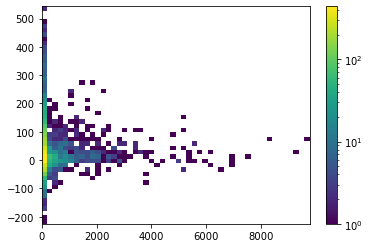

In [88]:
plt.hist2d(tor_rap["SBCAPE"], tor_rap["HLCY"], 50, norm=LogNorm(), cmin=1)
plt.colorbar()

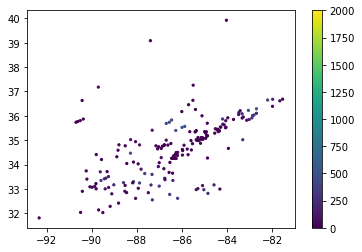

In [100]:
idx = tor_rap["date"] == "2011-04-27"
plt.scatter(tor_rap.loc[idx, "slon"], tor_rap.loc[idx, "slat"], 5, tor_rap.loc[idx, "SBCAPE"], vmin=0, vmax=2000)
plt.colorbar()

In [103]:
tor_rap.loc[idx, "SBCAPE"].max()

519.0

In [106]:
patch = pd.read_parquet("/glade/scratch/cbecker/test_crisis_data/cam_dataframes/ncar_NSC_3km_patches_2011-03-09-0000_2011-03-10-1200.parquet")

In [109]:
for col in patch.columns:
    print(col)

Q2
T2
PSFC
U10
V10
RAINNC
W_UP_MAX
W_DN_MAX
REFD_MAX
REFL_1KM_AGL
REFL_COM
UP_HELI_MAX
UP_HELI_MAX03
UP_HELI_MAX01
UP_HELI_MIN
RVORT1_MAX
RVORT5_MAX
GRPL_MAX
HAIL_MAXK1
HAIL_MAX2D
SBCAPE
MLCAPE
MUCAPE
SBCINH
MLCINH
MUCINH
SBLCL
MLLCL
USHR1
USHR6
VSHR1
VSHR6
U_BUNK
V_BUNK
SRH01
SRH03
TD2
PREC_ACC_NC
HAILCAST_DIAM_MAX
U_PL_1000
V_PL_1000
T_PL_1000
GHT_PL_1000
TD_PL_1000
Q_PL_1000
U_PL_925
V_PL_925
T_PL_925
GHT_PL_925
TD_PL_925
Q_PL_925
U_PL_850
V_PL_850
T_PL_850
GHT_PL_850
TD_PL_850
Q_PL_850
U_PL_700
V_PL_700
T_PL_700
GHT_PL_700
TD_PL_700
Q_PL_700
U_PL_600
V_PL_600
T_PL_600
GHT_PL_600
TD_PL_600
Q_PL_600
U_PL_500
V_PL_500
T_PL_500
GHT_PL_500
TD_PL_500
Q_PL_500
U_PL_400
V_PL_400
T_PL_400
GHT_PL_400
TD_PL_400
Q_PL_400
U_PL_300
V_PL_300
T_PL_300
GHT_PL_300
TD_PL_300
Q_PL_300
U_PL_250
V_PL_250
T_PL_250
GHT_PL_250
TD_PL_250
Q_PL_250
U_PL_200
V_PL_200
T_PL_200
GHT_PL_200
TD_PL_200
Q_PL_200
U_PL_150
V_PL_150
T_PL_150
GHT_PL_150
TD_PL_150
Q_PL_150
U_PL_100
V_PL_100
T_PL_100
GHT_PL_100
TD_PL_100
Q

<AxesSubplot:>

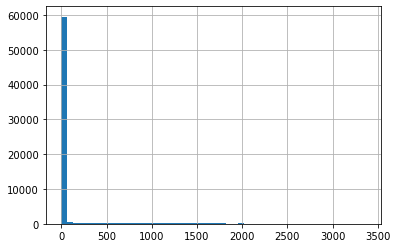

In [114]:
patch["SBCAPE"]

In [50]:
import os
from glob import glob
from os.path import join
rap_path = "/glade/p/cisl/aiml/conv_risk_intel/rap_ncei/"
dates = sorted(os.listdir(rap_path))
missing_files = {"date": [], "missing_files": []}
for date in dates:
    grib_files = sorted(glob(join(rap_path, date, "*.grb2")))
    if len(grib_files) < 24:
        print(date, 24-len(grib_files))
        missing_files["date"].append(date)
        missing_files["missing_files"].append(24-len(grib_files))
missing_df = pd.DataFrame(missing_files)
missing_df.to_csv("/glade/p/cisl/aiml/conv_risk_intel/rap_grib_missing_date_counts.csv", index=None)

20070413 13
20070414 9
20070415 2
20070416 14
20070417 4
20070418 6
20070419 7
20070420 8
20070421 9
20070422 5
20070423 1
20070424 1
20070425 1
20070426 1
20070427 1
20070428 6
20070429 1
20070430 20
20070501 1
20070502 1
20070503 5
20070504 1
20070505 4
20070506 1
20070507 1
20070508 12
20070509 18
20070510 1
20070511 7
20070512 1
20070513 1
20070514 2
20070515 12
20070516 1
20070517 7
20070518 13
20070519 18
20070520 1
20070521 4
20070522 1
20070523 1
20070524 1
20070525 2
20070526 1
20070527 1
20070528 1
20070529 1
20070530 1
20070531 1
20070601 1
20070602 1
20070603 1
20070604 7
20070605 1
20070606 6
20070607 1
20070608 8
20070609 7
20070610 1
20070611 1
20070612 7
20070613 6
20070614 19
20070615 7
20070616 1
20070617 5
20070618 2
20070619 4
20070620 1
20070621 12
20070622 7
20070623 1
20070624 1
20070625 1
20070626 7
20070627 7
20070628 1
20070629 13
20070630 6
20070701 10
20070702 10
20070703 6
20070704 1
20070705 2
20070706 1
20070707 1
20070708 5
20070709 1
20070710 9
20070711